In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Data Preparation

In [2]:
# load the dataset
train_df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', names=['text', 'emotion'], sep=';')
val_df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt', names=['text', 'emotion'], sep=';')
test_df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', names=['text', 'emotion'], sep=';')

In [3]:
train_df.shape

(16000, 2)

In [4]:
train_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Quick EDA

## Unique emotions

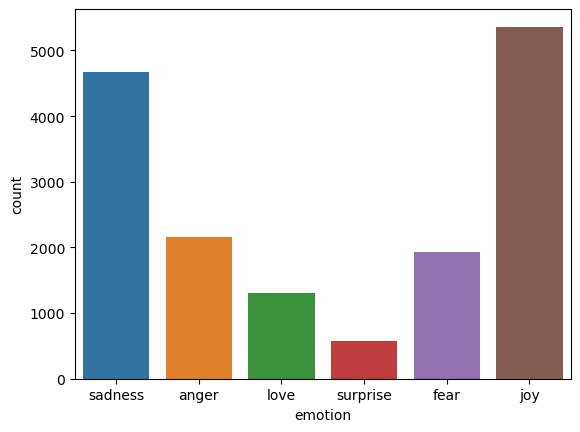

In [5]:
sns.countplot(data=train_df, x="emotion");

In [6]:
# encode the emotion column
le = LabelEncoder()
train_df['emotion'] = le.fit_transform(train_df['emotion'])
val_df['emotion']=le.fit_transform(val_df['emotion'])

**Imbalance can be seen in the labels**

In [7]:
import spacy

In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
# convert it into one sentence without stop words and punctuations(.,-) and also with the base words.

In [10]:
train_df['processed_text'] = train_df["text"].apply(preprocess)

In [11]:
train_df['processed_text']

0                                       not feel humiliate
1                  feel hopeless damned hopeful care awake
2                     m grab minute post feel greedy wrong
3                   feel nostalgic fireplace know property
4                                             feel grouchy
                               ...                        
15995           brief time beanbag say anna feel like beat
15996    turn feel pathetic wait table sub teaching degree
15997                             feel strong good overall
15998                      feel like rude comment m glad t
15999                         know lot feel stupid portray
Name: processed_text, Length: 16000, dtype: object

### Statistics about length of text

In [12]:
train_df['text_length'] = train_df['text'].apply(len)

In [13]:
summary = train_df['text_length'].describe()
summary

count    16000.000000
mean        96.845812
std         55.904953
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: text_length, dtype: float64

**maximum length** of the text in the dataset is 300 but 75% of the values are behind 129 and median is around 86 thus there's a skewness present in the dataset

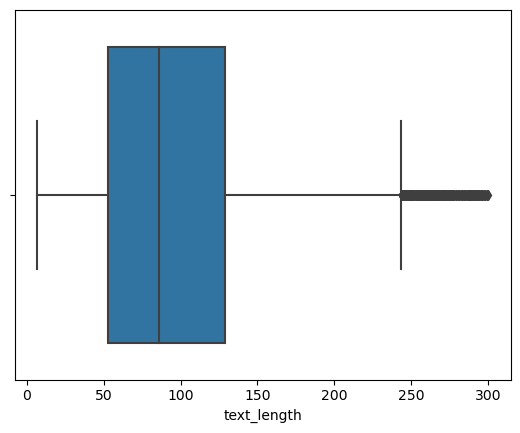

In [14]:
sns.boxplot(data=train_df, x='text_length');

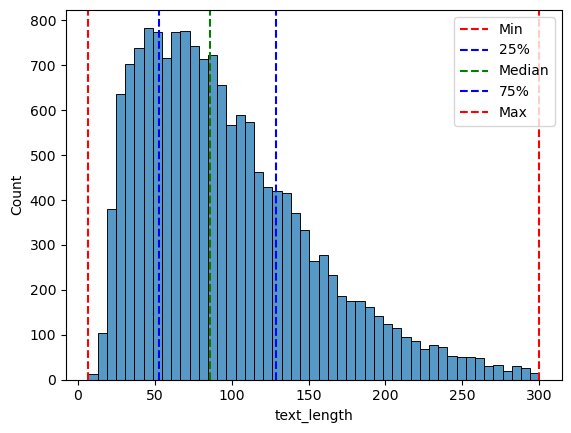

In [15]:
sns.histplot(data=train_df, x='text_length')
plt.axvline(summary['min'], color='r', linestyle='--', label='Min')
plt.axvline(summary['25%'], color='b', linestyle='--', label='25%')
plt.axvline(summary['50%'], color='g', linestyle='--', label='Median')
plt.axvline(summary['75%'], color='b', linestyle='--', label='75%')
plt.axvline(summary['max'], color='r', linestyle='--', label='Max')
plt.legend();

Since 75% of the values fall below length 129, using max_length 300 for our NLP algorithms would not be the best decision because it will result in sparser data because we will need to add a lot of padding to texts.

## Column Encoding

In [ ]:

# val_df['emotion'] = val_df['emotion'].map({
#     'joy' : 0, 
#     'sadness': 1, 
#     'anger': 2, 
#     'fear': 3,
#     'love': 4,
#     'surprise':5
# })

In [ ]:
val_df['emotion']

## Emotion Dataset

In [16]:
class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = str(self.df.loc[index, 'text'])
        emotion = self.df.loc[index, 'emotion']
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'emotion': torch.tensor(emotion, dtype=torch.long)
        }

## Tokenizer

In [17]:
# create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
# set the batch size
batch_size = 32

# set the maximum sequence length
max_len = 150

# create data loaders for the training and validation sets
train_dataset = EmotionDataset(train_df, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = EmotionDataset(val_df, tokenizer, max_len)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model

In [19]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertSentimentClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)
        output = self.fc1(pooled_output)
        output = self.dropout2(output)
        logits = self.fc2(output)
        
        return logits

In [20]:
bert_model_name = "bert-base-uncased"
num_classes = train_df["emotion"].nunique()
model = BertSentimentClassifier(bert_model_name, num_classes)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
criterion = nn.CrossEntropyLoss()

# Training

In [22]:
def train(model, data_loader, optimizer, criterion, device):
    # set the model to train mode
    model.train()
    
    # initialize the loss and accuracy 
    total_loss, total_accuracy = 0, 0
    
    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)
        
        # zero the gradient
        optimizer.zero_grad()
    
        # get the model's predictions
        outputs = model(input_ids, attention_mask)

        # get the loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        # accuracy calculation
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        total_accuracy += flat_accuracy(logits, label_ids)

        # perform backpropagation and optimization
        loss.backward()
        optimizer.step()

    # calculate the average loss
    avg_loss = total_loss / len(data_loader)
    avg_acc = total_accuracy / len(data_loader)


    return avg_loss, avg_acc

In [23]:
def evaluate(model, data_loader, criterion, device):
    # set the model to eval mode
    model.eval()
    
    # initialize the loss and accuracy variables
    total_loss = 0
    total_accuracy = 0
    
    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)
        
        # disable gradient computation
        with torch.no_grad():
            # get the model's predictions
            outputs = model(input_ids, attention_mask)
            
            # get the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # calculate the number of correct predictions
            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            total_accuracy += flat_accuracy(logits, label_ids)
    
    # calculate the average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = total_accuracy / len(data_loader)
    
    return avg_loss, accuracy

In [24]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set the learning rate
lr = 2e-5

# set the number of epochs
num_epochs = 10

# set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# move the model to the device
model.to(device)

# lists to store metrics
train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

# iterate over the epochs
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} ')
    # train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    
    # evaluate the model on the validation set
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # print the loss and accuracy
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
    # Save the loss and accuracy values
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save the model weights
    torch.save(model.state_dict(), f'weights_epoch{epoch + 1}.pt')

Epoch 1 


100%|██████████| 63/63 [00:11<00:00,  5.51it/s]


Train Loss: 0.6049 | Train Acc: 0.7860 | Val Loss: 0.1832 | Val Acc: 0.9320
Epoch 2 


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Train Loss: 0.1517 | Train Acc: 0.9405 | Val Loss: 0.1673 | Val Acc: 0.9281
Epoch 3 


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Train Loss: 0.1037 | Train Acc: 0.9518 | Val Loss: 0.1405 | Val Acc: 0.9425
Epoch 4 


100%|██████████| 63/63 [00:11<00:00,  5.51it/s]


Train Loss: 0.0857 | Train Acc: 0.9599 | Val Loss: 0.1514 | Val Acc: 0.9345
Epoch 5 


100%|██████████| 63/63 [00:11<00:00,  5.51it/s]


Train Loss: 0.0784 | Train Acc: 0.9617 | Val Loss: 0.1533 | Val Acc: 0.9395
Epoch 6 


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Train Loss: 0.0659 | Train Acc: 0.9684 | Val Loss: 0.1486 | Val Acc: 0.9385
Epoch 7 


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Train Loss: 0.0568 | Train Acc: 0.9741 | Val Loss: 0.1901 | Val Acc: 0.9400
Epoch 8 


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Train Loss: 0.0504 | Train Acc: 0.9789 | Val Loss: 0.1944 | Val Acc: 0.9355
Epoch 9 


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Train Loss: 0.0377 | Train Acc: 0.9844 | Val Loss: 0.2229 | Val Acc: 0.9400
Epoch 10 


100%|██████████| 63/63 [00:11<00:00,  5.52it/s]


Train Loss: 0.0348 | Train Acc: 0.9874 | Val Loss: 0.2328 | Val Acc: 0.9350


In [26]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the training loss curve
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(val_losses, label='Validation Loss')
    
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].legend()
    
    # Plot the training accuracy curve
    ax[1].plot(train_accuracies, label='Training Accuracy')
    ax[1].plot(val_accuracies, label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Training and Validation Accuracy')
    
    plt.show()


# Test

In [27]:
input_text = test_df.sample(n=1).text.values[0]
input_text

'i can choose to tell the whole word what im feeling now or just fake it with some happy stories'

In [28]:
encoded_input = tokenizer.encode_plus(
    input_text, 
    add_special_tokens=True,
    truncation=True,
    max_length= max_len,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
).to(device)

In [29]:
emotion_id = torch.argmax(model(**encoded_input), dim=1).item()

In [30]:
le.inverse_transform([emotion_id])

array(['sadness'], dtype=object)

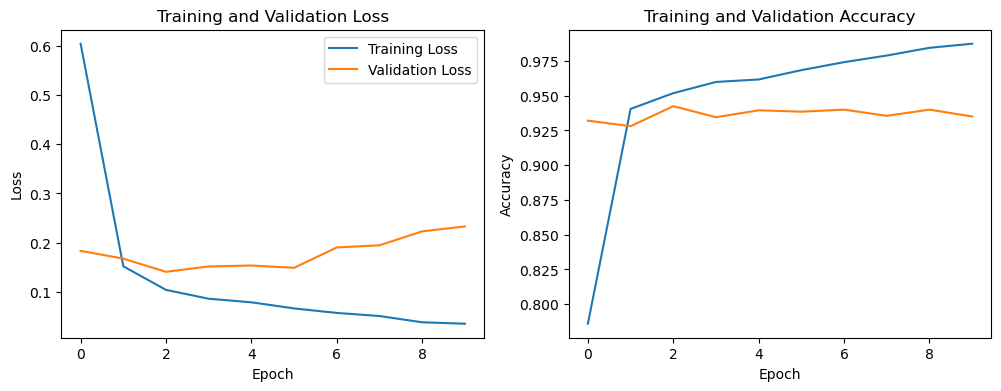

In [31]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)